In [40]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
    
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from time import time

#%matplotlib notebook

In [41]:
def plot(pred_data, true_data, model_name):
    print(true_data.shape)
    print(pred_data.shape)
    stps=10
    # LYAPUNOV TIME
    dt = 0.01
    pl = pred_data.shape[0]
    xp = pred_data[:,0]; xt= true_data[stps:(pl+stps),0]
    yp = pred_data[:,1]; yt= true_data[stps:(pl+stps),1]
    zp = pred_data[:,2]; zt= true_data[stps:(pl+stps),2]
    rmse = np.sqrt((xp-xt)**2+(yp-yt)**2+(zp-zt)**2)
    
    try:
        lyind = np.min(np.argwhere(rmse > 2.71828))
        lyaptime = (lyind-1)*dt
    except: 
        lyind = 0
        lyaptime = 0

    tp = np.linspace(0, dt*pl, pl)
    print('Model {} Lyapunov time = {}'.format(model_name, lyaptime))

    fig, ax = plt.subplots(2,2)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.suptitle('Rossler System Forecast (Type 2) - Model {} (true vs. pred)'.format(model_name), fontsize=16)
    plt.subplots_adjust(hspace=0.5)
    ax[0,0].plot(tp, xp, c='orange', lw = 1)
    ax[0,0].plot(tp, xt, c='black', linestyle='dashed', lw = 0.75)
    ax[0,0].set_xlabel('time')
    ax[0,0].set_ylabel('x')
    ax[0,0].set_title('x-axis')
    ax[0,0].legend( ['predicted','true'])
    
    ax[0,1].plot(tp, yp, c='orange', lw = 1)
    ax[0,1].plot(tp, yt, c='black', linestyle='dashed', lw = 0.75)
    ax[0,1].set_xlabel('time')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title('y-axis')
    ax[0,1].legend( ['predicted','true'])
    
    ax[1,0].plot(tp, zp, c='orange', lw = 1)
    ax[1,0].plot(tp, zt, c='black', linestyle='dashed', lw = 0.75)
    ax[1,0].set_xlabel('time')
    ax[1,0].set_ylabel('z')
    ax[1,0].set_title('z-axis')
    ax[1,0].legend( ['predicted','true'])
    
    ax[1,1].plot(tp, rmse, c='orange', lw = 1)
    ax[1,1].vlines(lyaptime, ymin = np.min(rmse), ymax=np.max(rmse), color = 'red') 
    ax[1,1].set_xlabel('time')
    ax[1,1].set_ylabel('distance (rmse)')
    ax[1,1].set_title('Euclidean distance vs Time')
    plt.savefig('rossler-{}'.format(model_name), bbox_inches='tight',dpi = 200)

    # 3D Plot of Lorenz System
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xt,yt,zt, lw=0.5, alpha=0.75, c='black')
    ax.plot(xp,yp,zp, lw=0.5, alpha=1, c='orange')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('{} Model - Rossler System (pred vs. true)'.format(model_name))  # Plot contour curves
    plt.savefig('3d-rossler-{}'.format(model_name), bbox_inches='tight', dpi = 200)

## Generating Rossler System data

In [42]:
def Rossler(x, t, a = 0.1, b = 0.1, c = 18):
    x,y,z = x
    dfdt = [-y-z, x+a*y, b+ z*(x-c)]
    return dfdt

# initial conditions
dt = 0.01
train_pts = 50001
x0_train = [5,5,5]

t = np.linspace(0, dt*train_pts, train_pts)

ross_param = (0.1,0.1,18)
sol = odeint(Rossler, x0_train, t, args=ross_param)

x = sol[:,0]; y = sol[:,1]; z = sol[:,2]
input_data = np.array([x,y,z]).T
print('input_data shape:',input_data.shape)

input_data shape: (50001, 3)


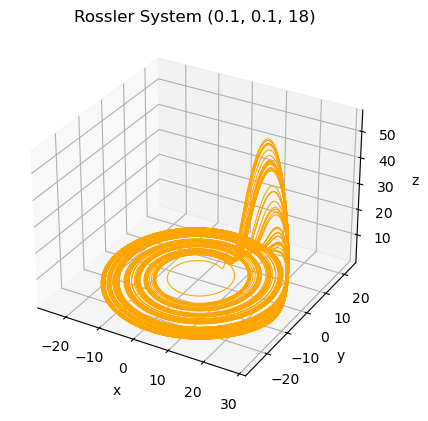

In [43]:
# Plotting Lorenz System data
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x,y,z, c='orange', lw = 0.75, alpha = 1)  # Plot contour curves

ax.set_xlabel('x')  # Plot contour curves
ax.set_ylabel('y')  # Plot contour curves
ax.set_zlabel('z')  # Plot contour curves
ax.set_title('Rossler System {}'.format(ross_param))  # Plot contour curves
plt.show()

## Training Input Data

In [44]:
out_step = 1
in_steps = 10
train_pts = 50000
samples = train_pts-in_steps-out_step

train_input = np.zeros((samples, in_steps, 3))
print('RNN data shape (batches, timesteps, dim):',train_input.shape)

for i in range(samples):
    train_input[i,:,:] = input_data[i:i+in_steps,:]
    
print('first batch {x_1,x_2,...,x_10}):\n', train_input[0])

RNN data shape (batches, timesteps, dim): (49989, 10, 3)
first batch {x_1,x_2,...,x_10}):
 [[5.         5.         5.        ]
 [4.90284096 5.05453801 4.38925053]
 [4.81088657 5.1081851  3.84957934]
 [4.72347347 5.16098909 3.3733529 ]
 [4.64001068 5.21299154 2.95363278]
 [4.55997289 5.26422851 2.58413974]
 [4.48289413 5.3147311  2.25921224]
 [4.40836182 5.3645261  1.97376265]
 [4.33601136 5.41363641 1.72323233]
 [4.26552105 5.46208153 1.50354705]]


## Training Output Data

In [45]:
train_output = np.zeros((samples, 3))
for i in range(samples):
    train_output[i] = input_data[i+in_steps]

print('output shape:',train_output.shape)
print('first target batch x_{11}:', train_output[0])

output shape: (49989, 3)
first target batch x_{11}: [4.19660751 5.50987795 1.3110738 ]


## 1) Build GRU Network

In [46]:
input_dim = 3; output_size=3
gru_units = 100
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50,100],[1e-2,1e-3,1e-4])

LayerGRU = layers.RNN(layers.GRUCell(gru_units), input_shape=(None, input_dim))

GRUmodel = tf.keras.Sequential([LayerGRU,
                                layers.Dense(output_size)])

GRUmodel.compile(loss=tf.keras.losses.Huber(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 metrics=['mse'])

## 2) Build LSTM Network

In [47]:
input_dim = 3; output_size=3
lstm_units = 100
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50,100],[1e-2,1e-3,1e-4])

LayerLSTM = layers.RNN(layers.LSTMCell(lstm_units), input_shape=(None, input_dim))

LSTMmodel = tf.keras.Sequential([LayerLSTM,
                                 layers.Dense(output_size)])

LSTMmodel.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['mse'])

## 3) Build ESN Network

In [48]:
input_dim = 3; output_size=3
esn_units = 100
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50,100],[1e-2,1e-3,1e-4])

ESNmodel = tf.keras.Sequential([tfa.layers.ESN(esn_units, connectivity = 0.05, leaky = 0.1, spectral_radius = 0.8),
                                layers.Dense(output_size)]) 

ESNmodel.compile(loss=tf.keras.losses.Huber(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 metrics=['mse'])

In [49]:
historyGRU = GRUmodel.fit(train_input, train_output, verbose=1, epochs=150)

Epoch 1/150
1563/1563 [==============================] - 21s 13ms/step - loss: 0.2832 - mse: 3.3718
Epoch 2/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0844 - mse: 1.5674
Epoch 3/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0534 - mse: 0.8904
Epoch 4/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0330 - mse: 0.4680
Epoch 5/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0195 - mse: 0.2225
Epoch 6/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0109 - mse: 0.0985
Epoch 7/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0058 - mse: 0.0431
Epoch 8/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0034 - mse: 0.0211
Epoch 9/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0021 - mse: 0.0103
Epoch 10/150
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0013 - mse: 0.0048

1563/1563 [==============================] - 21s 13ms/step - loss: 6.1725e-05 - mse: 1.2345e-04
Epoch 78/150
1563/1563 [==============================] - 21s 13ms/step - loss: 8.1260e-05 - mse: 1.6252e-04
Epoch 79/150
1563/1563 [==============================] - 20s 13ms/step - loss: 6.1236e-05 - mse: 1.2247e-04
Epoch 80/150
1563/1563 [==============================] - 21s 13ms/step - loss: 6.4566e-05 - mse: 1.2913e-04
Epoch 81/150
1563/1563 [==============================] - 20s 13ms/step - loss: 5.3698e-05 - mse: 1.0740e-04
Epoch 82/150
1563/1563 [==============================] - 20s 13ms/step - loss: 6.9202e-05 - mse: 1.3840e-04
Epoch 83/150
1563/1563 [==============================] - 20s 13ms/step - loss: 5.1619e-05 - mse: 1.0324e-04
Epoch 84/150
1563/1563 [==============================] - 20s 13ms/step - loss: 4.8249e-05 - mse: 9.6497e-05
Epoch 85/150
1563/1563 [==============================] - 20s 13ms/step - loss: 5.8873e-05 - mse: 1.1775e-04
Epoch 86/150
1563/1563 [========

In [50]:
historyLSTM = LSTMmodel.fit(train_input, train_output, verbose=1, epochs=150)

Epoch 1/150
1563/1563 [==============================] - 23s 14ms/step - loss: 0.3665 - mse: 5.0483
Epoch 2/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.1414 - mse: 2.6800
Epoch 3/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0957 - mse: 1.7784
Epoch 4/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0641 - mse: 1.0869
Epoch 5/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0415 - mse: 0.6057
Epoch 6/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0272 - mse: 0.3326
Epoch 7/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0172 - mse: 0.1740
Epoch 8/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0103 - mse: 0.0861
Epoch 9/150
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0058 - mse: 0.0401
Epoch 10/150
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0037 - mse: 0.0209

1563/1563 [==============================] - 22s 14ms/step - loss: 1.2372e-04 - mse: 2.4910e-04
Epoch 78/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1392e-04 - mse: 2.2861e-04
Epoch 79/150
1563/1563 [==============================] - 22s 14ms/step - loss: 8.0870e-05 - mse: 1.6174e-04
Epoch 80/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0817e-04 - mse: 2.1634e-04
Epoch 81/150
1563/1563 [==============================] - 22s 14ms/step - loss: 9.5125e-05 - mse: 1.9025e-04
Epoch 82/150
1563/1563 [==============================] - 21s 14ms/step - loss: 8.3889e-05 - mse: 1.6778e-04
Epoch 83/150
1563/1563 [==============================] - 22s 14ms/step - loss: 9.6882e-05 - mse: 1.9376e-04
Epoch 84/150
1563/1563 [==============================] - 22s 14ms/step - loss: 9.3214e-05 - mse: 1.8643e-04
Epoch 85/150
1563/1563 [==============================] - 22s 14ms/step - loss: 9.6186e-05 - mse: 1.9237e-04
Epoch 86/150
1563/1563 [========

In [51]:
historyESN = ESNmodel.fit(train_input, train_output, verbose=1, epochs=150)

Epoch 1/150
1563/1563 [==============================] - 3s 1ms/step - loss: 1.5334 - mse: 11.6871
Epoch 2/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3496 - mse: 8.8645
Epoch 3/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.2735 - mse: 7.7620
Epoch 4/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.2182 - mse: 6.9650
Epoch 5/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.1775 - mse: 6.3925
Epoch 6/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.1465 - mse: 5.9788
Epoch 7/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.1210 - mse: 5.6643
Epoch 8/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.0988 - mse: 5.4152
Epoch 9/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.0784 - mse: 5.2056
Epoch 10/150
1563/1563 [==============================] - 2s 1ms/step - loss: 1.0593 - mse: 5.0304
Epoch 11/150
1563/

1563/1563 [==============================] - 2s 1ms/step - loss: 0.2270 - mse: 0.9072
Epoch 84/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2242 - mse: 0.8964
Epoch 85/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2216 - mse: 0.8879
Epoch 86/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2191 - mse: 0.8787
Epoch 87/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2167 - mse: 0.8696
Epoch 88/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2144 - mse: 0.8621
Epoch 89/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2123 - mse: 0.8535
Epoch 90/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2103 - mse: 0.8462
Epoch 91/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2083 - mse: 0.8381
Epoch 92/150
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2065 - mse: 0.8310
Epoch 93/150
1563/1563 

## Test Input data

In [52]:
# MODEL FORECAST
x0_test = train_output[-1]
print('test initial cond:', x0_test)
test_pts = 5001
t_test = np.linspace(t[-1], t[-1]+dt*test_pts, test_pts)
solt = odeint(Rossler, x0_test, t_test, args=ross_param)
xt = solt[:,0]; yt = solt[:,1]; zt = solt[:,2]
test_data = np.array([xt,yt,zt]).T

samplest = test_pts-in_steps-out_step
test_input = np.zeros((samplest-1, in_steps, 3))
test_target = np.zeros((samplest-1, 3))

for i in range(samplest-1):
    test_input[i,:,:] = test_data[i:i+in_steps,:]
    test_target[i,:] = test_data[i+in_steps+1]

print('RNN test data shape (batches, timesteps, dim):',test_input.shape)
print('RNN target data shape:',test_target.shape)

test initial cond: [1.38611198e+00 1.94653704e+01 1.91561353e-02]
RNN test data shape (batches, timesteps, dim): (4989, 10, 3)
RNN target data shape: (4989, 3)


## Forecast one step into the future for test data sequences

In [53]:
def forecast_t1_plot(models, test_input, test_target, units):
    pres_list = []
    for model in models:
        pres_list.append(model.predict(test_input))
    
    pl = test_target.shape[0]
    tp = np.linspace(0, dt*pl, pl)
    
    fig, ax = plt.subplots(2,2)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.suptitle('Rossler System Forecast (Type 1) - (true vs. pred)', fontsize=16)
    plt.subplots_adjust(hspace=0.5)
    
    xg = pres_list[0][:,0]; yg = pres_list[0][:,1]; zg = pres_list[0][:,2]
    xl = pres_list[1][:,0]; yl = pres_list[1][:,1]; zl = pres_list[1][:,2]
    xe = pres_list[2][:,0]; ye = pres_list[2][:,1]; ze = pres_list[2][:,2]
    xt = test_target[:,0]; yt = test_target[:,1]; zt = test_target[:,2]

    grmse = np.sqrt((xg-xt)**2+(yg-yt)**2+(zg-zt)**2)
    lrmse = np.sqrt((xl-xt)**2+(yl-yt)**2+(zl-zt)**2)
    ermse = np.sqrt((xe-xt)**2+(ye-yt)**2+(ze-zt)**2)
    
    ax[0,0].plot(tp, xg, c='dodgerblue', linestyle='dashed', lw = 1)
    ax[0,0].plot(tp, xl, c='darkorange', linestyle='dashed', lw = 1)
    ax[0,0].plot(tp, xe, c='crimson', linestyle='dashed', lw = 1)
    ax[0,0].plot(tp, xt, c='black', lw = 0.75)
    ax[0,0].set_xlabel('time')
    ax[0,0].set_ylabel('x')
    ax[0,0].set_title('x-axis')
    ax[0,0].legend(['gru-pred','lstm-pred','esn-pred','true'], loc = 'upper right')
    
    ax[0,1].plot(tp, yg, c='dodgerblue', linestyle='dashed', lw = 1)
    ax[0,1].plot(tp, yl, c='darkorange', linestyle='dashed', lw = 1)
    ax[0,1].plot(tp, ye, c='crimson', linestyle='dashed', lw = 1)
    ax[0,1].plot(tp, yt, c='black', lw = 0.75)
    ax[0,1].set_xlabel('time')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title('y-axis')
    ax[0,1].legend(['gru-pred','lstm-pred','esn-pred','true'], loc = 'upper right')
    
    ax[1,0].plot(tp, zg, c='dodgerblue', linestyle='dashed', lw = 1)
    ax[1,0].plot(tp, zl, c='darkorange', linestyle='dashed', lw = 1)
    ax[1,0].plot(tp, ze, c='crimson', linestyle='dashed', lw = 1)
    ax[1,0].plot(tp, zt, c='black', lw = 0.75)
    ax[1,0].set_xlabel('time')
    ax[1,0].set_ylabel('z')
    ax[1,0].set_title('z-axis')
    ax[1,0].legend(['gru-pred','lstm-pred','esn-pred','true'], loc = 'upper right')
    
    ax[1,1].plot(tp, grmse, c='dodgerblue', linestyle='dashed', lw = 1)
    ax[1,1].plot(tp, lrmse, c='darkorange', linestyle='dashed', lw = 1)
    ax[1,1].plot(tp, ermse, c='crimson', linestyle='dashed', lw = 1)
    ax[1,1].set_xlabel('time')
    ax[1,1].set_ylabel('distance (rmse)')
    ax[1,1].set_title('RSE vs Time')
    ax[1,1].legend(['gru-pred','lstm-pred','esn-pred','true'], loc = 'upper right')
    plt.savefig('rossler-t1-{}'.format(units), bbox_inches='tight',dpi = 200)

156/156 [==============================] - 0s 1ms/step


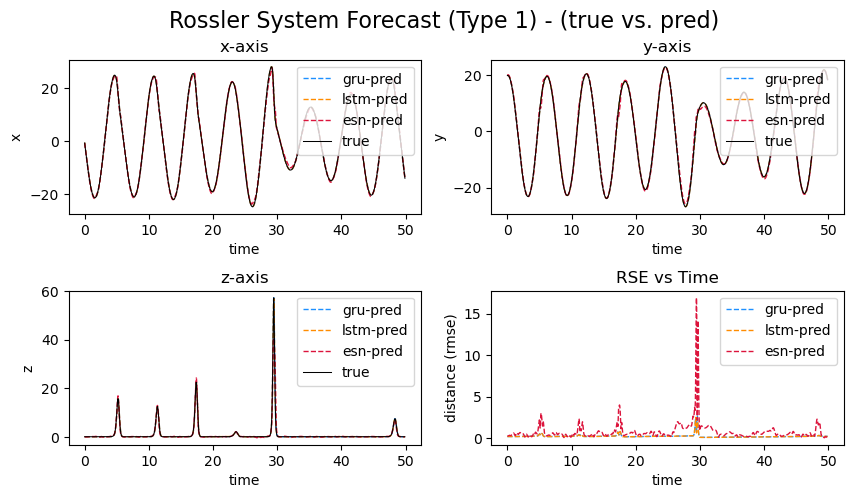

In [54]:
models = [GRUmodel, LSTMmodel, ESNmodel]
units=100
forcast_t1_plot(models, test_input, test_target, units)

## Forecast N steps into the future until divergence

In [55]:
def forecast_t2(model, test_input, in_steps, samples):
    # warmup we have get in_steps' predictions as initial conditions
    # to allow model forecast from predictions
    hat=np.zeros((samples, in_steps, 3))
    
    # use first 10 inputs (10,10,3) to get an initial condition
    for j in range(in_steps):
        tin = np.zeros((1, in_steps, 3))
        tin[0] = test_input[j]
        hat[0,j] = model.predict(tin)
    print('init cond terminated')
    
    # generate predictions from initial last 10 predictions
    predseq = np.zeros((samples-in_steps, 3))
    for i in range(1,samples-in_steps):
        tin = np.zeros((1, in_steps, 3))
        tin[0] = hat[i-1]
        pred = model(tin)
        predseq[i-1] = pred
        # put last 9 steps from 'i-1' as first 9 steps in 'i'
        hat[i,0:(in_steps-1)]=hat[i-1,1:in_steps]
        hat[i,-1] = pred[0]
    print('forecast terminated')
    return(predseq)

In [56]:
gru_pred=forcast_t2(model=GRUmodel,test_input=test_input,in_steps=10,samples=1000)

1/1 [==============================] - 0s 13ms/step
init cond terminated
forecast terminated


(5000, 3)
(989, 3)
Model GRU-100 Lyapunov time = 1.71


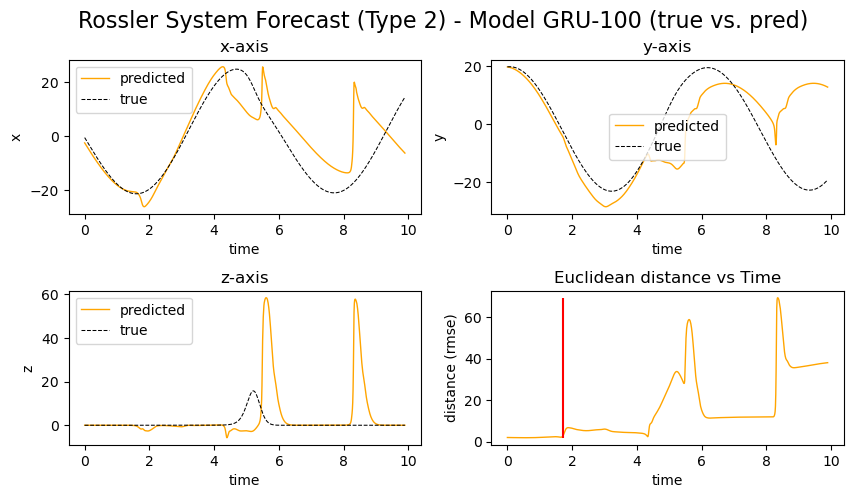

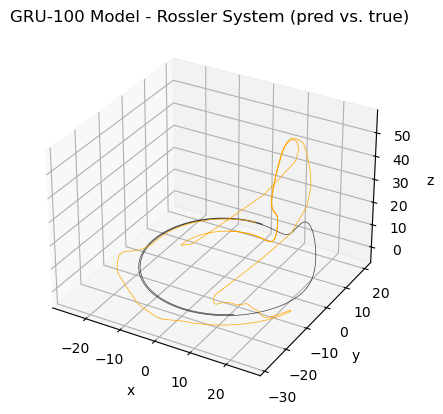

In [57]:
plot(pred_data=gru_pred[:-1], true_data=test_data[:-1], model_name='GRU-{}'.format(gru_units))
#Model GRU-10 Lyapunov time = 0.17
#Model GRU-25 Lyapunov time = 0.950
#Model GRU-50 Lyapunov time = 1.35
#Model GRU-100 Lyapunov time = 1.71

In [58]:
lstm_pred=forecast_t2(model=LSTMmodel,test_input=test_input,in_steps=10,samples=5000)

1/1 [==============================] - 0s 13ms/step
init cond terminated
forecast terminated


(5000, 3)
(4989, 3)
Model LSTM-100 Lyapunov time = 4.79


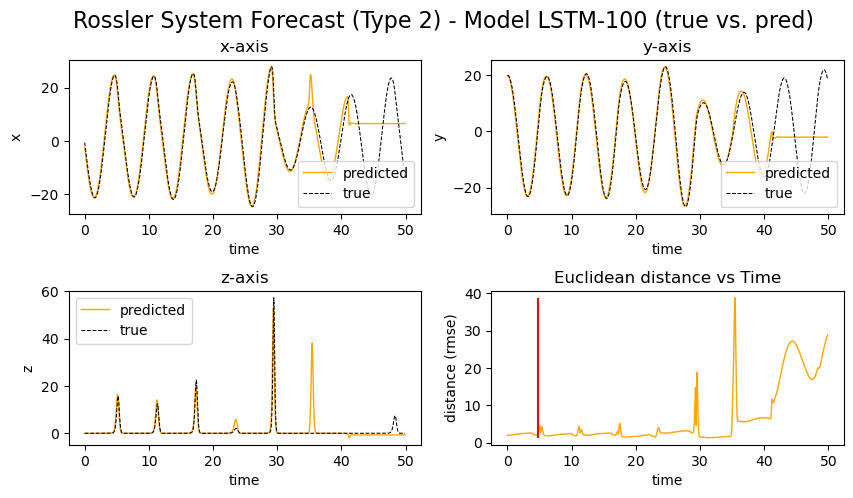

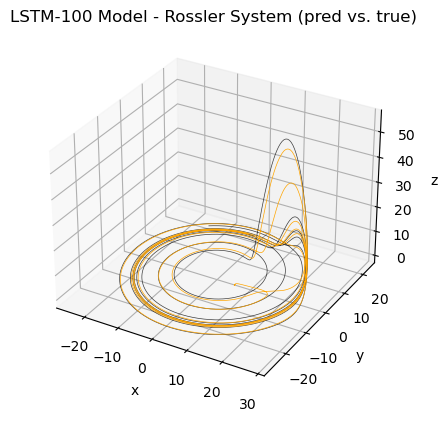

In [59]:
plot(pred_data=lstm_pred[:-1], true_data=test_data[:-1], model_name='LSTM-{}'.format(lstm_units))
#Model LSTM-10 Lyapunov time = 0.11
#Model LSTM-25 Lyapunov time = 2.68
#Model LSTM-50 Lyapunov time = 1.7
#Model LSTM-100 Lyapunov time = 4.79

In [60]:
esn_pred=forecast_t2(model=ESNmodel,test_input=test_input,in_steps=10,samples=1000)

1/1 [==============================] - 0s 15ms/step
init cond terminated
forecast terminated


(5000, 3)
(989, 3)
Model ESN-100 Lyapunov time = 0.02


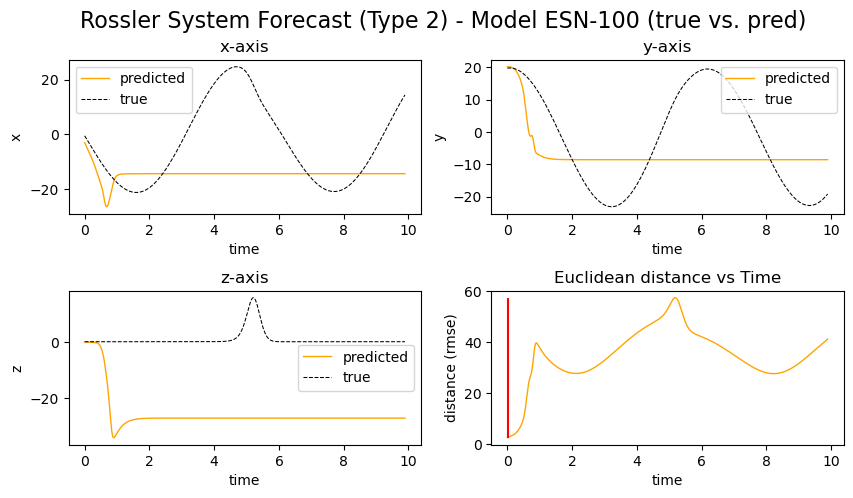

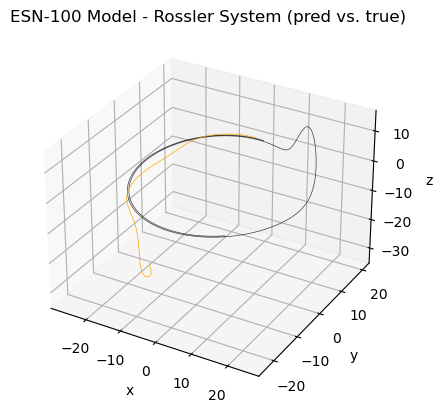

In [61]:
plot(pred_data=esn_pred[:-1], true_data=test_data[:-1], model_name='ESN-{}'.format(esn_units))
#Model ESN-10 Lyapunov time = 0.04
#Model ESN-25 Lyapunov time = 0.3
#Model ESN-50 Lyapunov time = 2.02
#Model ESN-100 Lyapunov time = 1.65

## LSTM trying different activations, recurrent_activations
activation = selu, tanh, relu

recurrent_activation = selu, tanh, relu

In [66]:
input_dim = 3; output_size=3
lstm_units = 100
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50,100],[1e-2,1e-3,1e-4])

LayerLSTMb = layers.RNN(layers.LSTMCell(lstm_units, activation = 'selu', 
                        recurrent_activation = 'sigmoid'), input_shape=(None, input_dim))
#sigmoid
LSTMmodelb = tf.keras.Sequential([LayerLSTM,
                                  layers.Dense(output_size)])

LSTMmodelb.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['mse'])

historyLSTMmodelb = LSTMmodelb.fit(train_input, train_output, verbose=1, epochs=150)

# relu didnt work well
# Model LSTM-tanh-selu Lyapunov time = 4.32
# Model LSTM-selu-sigmoid Lyapunov time = 4.23

Epoch 1/150
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3082 - mse: 4.7177
Epoch 2/150
1563/1563 [==============================] - 24s 15ms/step - loss: 0.1339 - mse: 2.7148
Epoch 3/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0967 - mse: 1.8557
Epoch 4/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0697 - mse: 1.2057
Epoch 5/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0498 - mse: 0.7540
Epoch 6/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0352 - mse: 0.4580
Epoch 7/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0243 - mse: 0.2632
Epoch 8/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0164 - mse: 0.1476
Epoch 9/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0107 - mse: 0.0809
Epoch 10/150
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0072 - mse: 0.0453

1563/1563 [==============================] - 22s 14ms/step - loss: 2.2508e-04 - mse: 4.5670e-04
Epoch 78/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.9351e-04 - mse: 3.8703e-04
Epoch 79/150
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1189e-04 - mse: 4.2378e-04
Epoch 80/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.9466e-04 - mse: 3.8931e-04
Epoch 81/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7788e-04 - mse: 3.5577e-04
Epoch 82/150
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1386e-04 - mse: 4.2772e-04
Epoch 83/150
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1042e-04 - mse: 4.2084e-04
Epoch 84/150
1563/1563 [==============================] - 22s 14ms/step - loss: 2.2534e-04 - mse: 4.5096e-04
Epoch 85/150
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8463e-04 - mse: 3.6926e-04
Epoch 86/150
1563/1563 [========

1/1 [==============================] - 0s 12ms/step
init cond terminated
forecast terminated
(5000, 3)
(4989, 3)
Model LSTM-selu-sigmoid Lyapunov time = 4.23


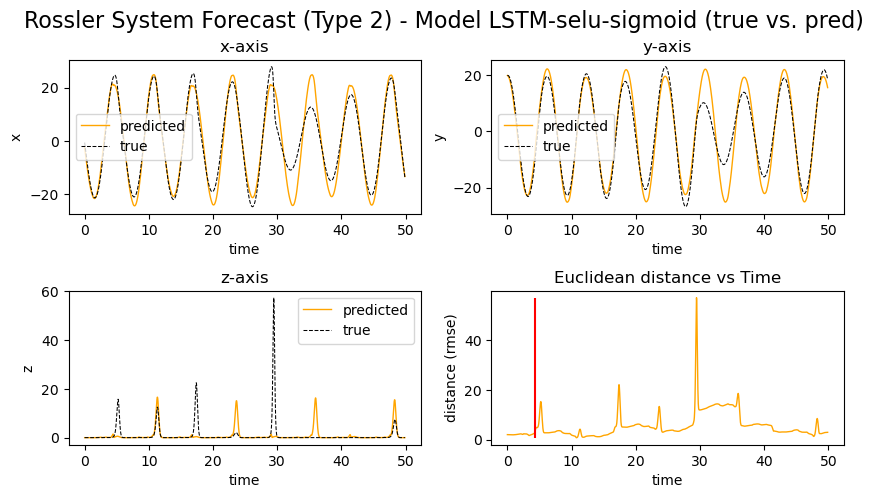

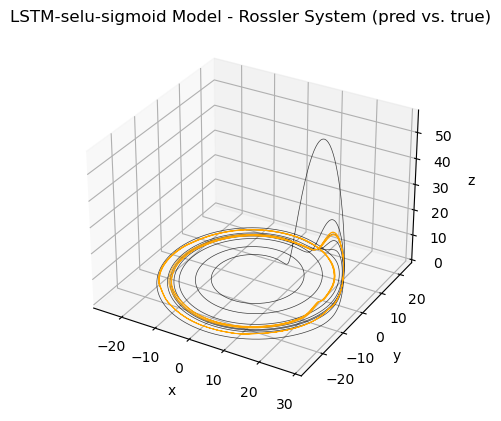

In [71]:
LSTMmodelb_pred=forcast_t2(model=LSTMmodelb,test_input=test_input,in_steps=10,samples=5000)
plot(pred_data=LSTMmodelb_pred[:-1], true_data=test_data[:-1],model_name='LSTM-selu-sigmoid')

## ESN hyper-parameter search

Model unit200 leaky 1 spec rad 50 saprsity 5
Epoch 1/150
1563/1563 [==============================] - 13s 7ms/step - loss: 4.7879 - mse: 55.1602
Epoch 2/150
1563/1563 [==============================] - 12s 7ms/step - loss: 3.9048 - mse: 39.7554
Epoch 3/150
1563/1563 [==============================] - 12s 7ms/step - loss: 3.0960 - mse: 28.4576
Epoch 4/150
1563/1563 [==============================] - 12s 7ms/step - loss: 2.3880 - mse: 20.1116
Epoch 5/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.8736 - mse: 14.5954
Epoch 6/150
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5488 - mse: 11.2999
Epoch 7/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3737 - mse: 9.5957
Epoch 8/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.2936 - mse: 8.8166
Epoch 9/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.2520 - mse: 8.3572
Epoch 10/150
1563/1563 [==============================] - 

1563/1563 [==============================] - 12s 8ms/step - loss: 0.7334 - mse: 2.9890
Epoch 83/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7294 - mse: 2.9680
Epoch 84/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7254 - mse: 2.9436
Epoch 85/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7215 - mse: 2.9226
Epoch 86/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7175 - mse: 2.9004
Epoch 87/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7136 - mse: 2.8769
Epoch 88/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7096 - mse: 2.8564
Epoch 89/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7056 - mse: 2.8335
Epoch 90/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7017 - mse: 2.8122
Epoch 91/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6978 - mse: 2.7904
Epoch 92/150


1563/1563 [==============================] - 12s 8ms/step - loss: 1.5322 - mse: 11.4345
Epoch 7/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3431 - mse: 9.5815
Epoch 8/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2569 - mse: 8.7106
Epoch 9/150
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2155 - mse: 8.2219
Epoch 10/150
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1863 - mse: 7.8328
Epoch 11/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1606 - mse: 7.4656
Epoch 12/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1372 - mse: 7.1303
Epoch 13/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.1158 - mse: 6.8187
Epoch 14/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0960 - mse: 6.5376
Epoch 15/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0777 - mse: 6.2793
Epoch 16/150
15

1563/1563 [==============================] - 11s 7ms/step - loss: 0.6366 - mse: 2.4715
Epoch 89/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6321 - mse: 2.4484
Epoch 90/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6276 - mse: 2.4254
Epoch 91/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6231 - mse: 2.4034
Epoch 92/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6187 - mse: 2.3810
Epoch 93/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6142 - mse: 2.3595
Epoch 94/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6098 - mse: 2.3373
Epoch 95/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6054 - mse: 2.3154
Epoch 96/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6010 - mse: 2.2941
Epoch 97/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5965 - mse: 2.2729
Epoch 98/150


1563/1563 [==============================] - 11s 7ms/step - loss: 1.1461 - mse: 6.9299
Epoch 13/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1212 - mse: 6.6175
Epoch 14/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0989 - mse: 6.3423
Epoch 15/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0788 - mse: 6.0956
Epoch 16/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0605 - mse: 5.8721
Epoch 17/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0439 - mse: 5.6719
Epoch 18/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0288 - mse: 5.4948
Epoch 19/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0151 - mse: 5.3331
Epoch 20/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0027 - mse: 5.1911
Epoch 21/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9914 - mse: 5.0604
Epoch 22/150


1563/1563 [==============================] - 11s 7ms/step - loss: 0.6159 - mse: 2.3843
Epoch 95/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6118 - mse: 2.3644
Epoch 96/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6077 - mse: 2.3429
Epoch 97/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6037 - mse: 2.3238
Epoch 98/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5997 - mse: 2.3028
Epoch 99/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5957 - mse: 2.2829
Epoch 100/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5916 - mse: 2.2632
Epoch 101/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5877 - mse: 2.2446
Epoch 102/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5837 - mse: 2.2244
Epoch 103/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5798 - mse: 2.2055
Epoch 104

1563/1563 [==============================] - 11s 7ms/step - loss: 1.0890 - mse: 6.0356
Epoch 19/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0743 - mse: 5.8692
Epoch 20/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0610 - mse: 5.7132
Epoch 21/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0489 - mse: 5.5804
Epoch 22/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0379 - mse: 5.4555
Epoch 23/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0279 - mse: 5.3448
Epoch 24/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0187 - mse: 5.2402
Epoch 25/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0103 - mse: 5.1482
Epoch 26/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0024 - mse: 5.0650
Epoch 27/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9950 - mse: 4.9864
Epoch 28/150


1563/1563 [==============================] - 11s 7ms/step - loss: 0.6441 - mse: 2.4973
Epoch 101/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6400 - mse: 2.4746
Epoch 102/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6359 - mse: 2.4522
Epoch 103/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6317 - mse: 2.4297
Epoch 104/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6276 - mse: 2.4078
Epoch 105/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6235 - mse: 2.3880
Epoch 106/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6194 - mse: 2.3659
Epoch 107/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6153 - mse: 2.3441
Epoch 108/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6113 - mse: 2.3238
Epoch 109/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6072 - mse: 2.3027
Epoc

1563/1563 [==============================] - 11s 7ms/step - loss: 1.0263 - mse: 5.2356
Epoch 25/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0183 - mse: 5.1455
Epoch 26/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0110 - mse: 5.0625
Epoch 27/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0040 - mse: 4.9872
Epoch 28/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9975 - mse: 4.9158
Epoch 29/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9913 - mse: 4.8508
Epoch 30/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9854 - mse: 4.7901
Epoch 31/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9798 - mse: 4.7319
Epoch 32/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9743 - mse: 4.6768
Epoch 33/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9690 - mse: 4.6274
Epoch 34/150


Epoch 106/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6665 - mse: 2.5729
Epoch 107/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6628 - mse: 2.5513
Epoch 108/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6590 - mse: 2.5322
Epoch 109/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6553 - mse: 2.5135
Epoch 110/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6516 - mse: 2.4929
Epoch 111/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6480 - mse: 2.4753
Epoch 112/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6443 - mse: 2.4548
Epoch 113/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6407 - mse: 2.4361
Epoch 114/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6370 - mse: 2.4183
Epoch 115/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6333 - ms

1563/1563 [==============================] - 12s 7ms/step - loss: 0.9684 - mse: 4.6843
Epoch 31/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9629 - mse: 4.6258
Epoch 32/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9576 - mse: 4.5698
Epoch 33/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9525 - mse: 4.5188
Epoch 34/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9475 - mse: 4.4688
Epoch 35/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9426 - mse: 4.4215
Epoch 36/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9378 - mse: 4.3761
Epoch 37/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9331 - mse: 4.3331
Epoch 38/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9285 - mse: 4.2914
Epoch 39/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9239 - mse: 4.2522
Epoch 40/150


1563/1563 [==============================] - 11s 7ms/step - loss: 0.6409 - mse: 2.4367
Epoch 112/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6374 - mse: 2.4188
Epoch 113/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6340 - mse: 2.4020
Epoch 114/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6305 - mse: 2.3839
Epoch 115/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6271 - mse: 2.3669
Epoch 116/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6237 - mse: 2.3500
Epoch 117/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6202 - mse: 2.3331
Epoch 118/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6168 - mse: 2.3144
Epoch 119/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6135 - mse: 2.2985
Epoch 120/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6101 - mse: 2.2823
Epoc

1563/1563 [==============================] - 11s 7ms/step - loss: 0.1241 - mse: 0.5279
Epoch 36/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1201 - mse: 0.5105
Epoch 37/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1168 - mse: 0.4968
Epoch 38/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1138 - mse: 0.4827
Epoch 39/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1112 - mse: 0.4705
Epoch 40/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1089 - mse: 0.4595
Epoch 41/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1068 - mse: 0.4486
Epoch 42/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1049 - mse: 0.4393
Epoch 43/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1032 - mse: 0.4299
Epoch 44/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1015 - mse: 0.4216
Epoch 45/150


1563/1563 [==============================] - 11s 7ms/step - loss: 0.0572 - mse: 0.1824
Epoch 117/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0569 - mse: 0.1809
Epoch 118/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0566 - mse: 0.1795
Epoch 119/150
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0563 - mse: 0.1780
Epoch 120/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0559 - mse: 0.1768
Epoch 121/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0557 - mse: 0.1755
Epoch 122/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0554 - mse: 0.1740
Epoch 123/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0551 - mse: 0.1729
Epoch 124/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0548 - mse: 0.1716
Epoch 125/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0545 - mse: 0.1705
Epoc

KeyboardInterrupt: 

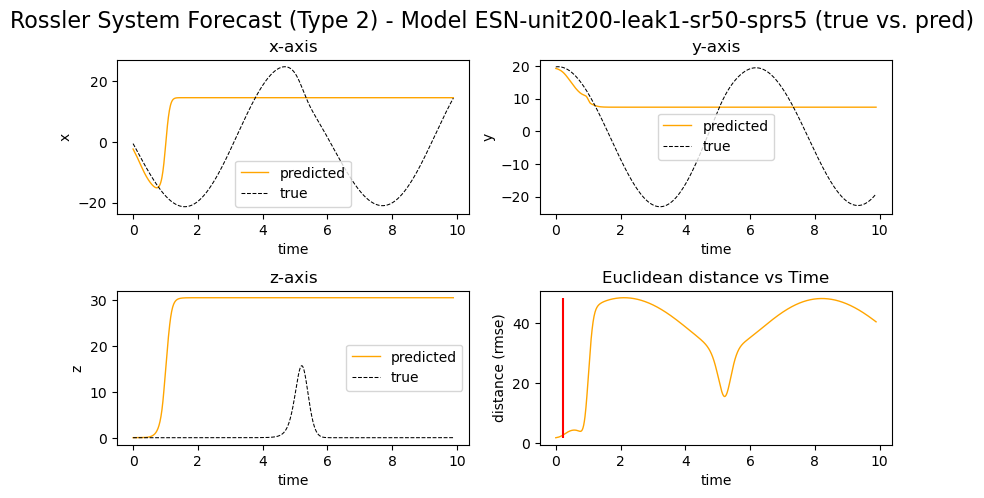

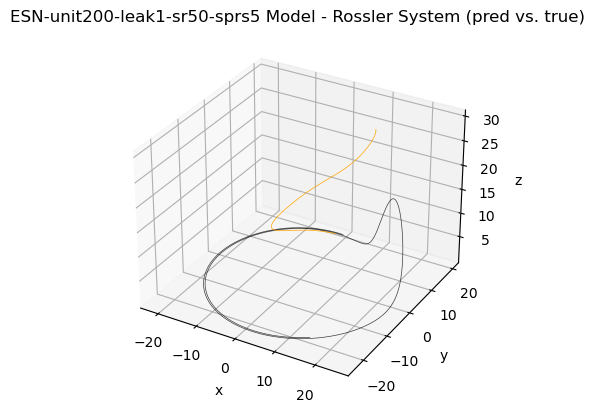

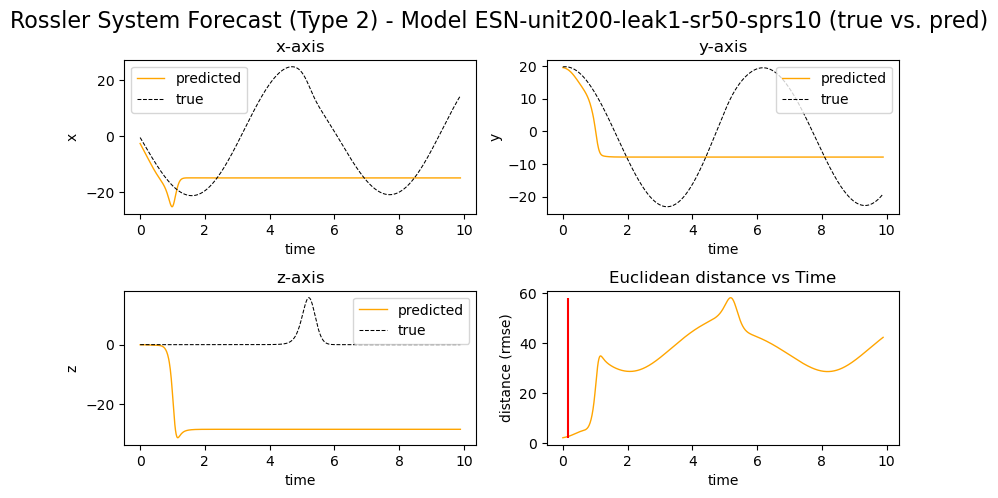

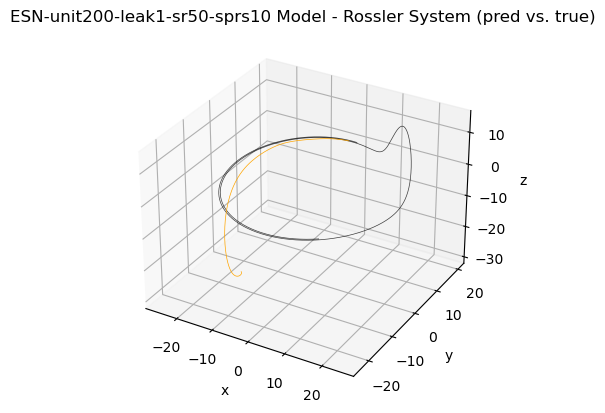

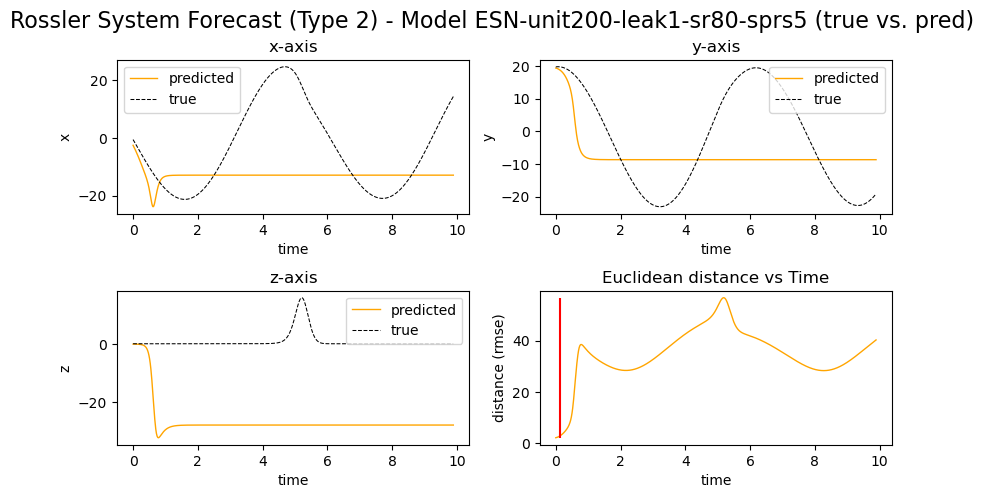

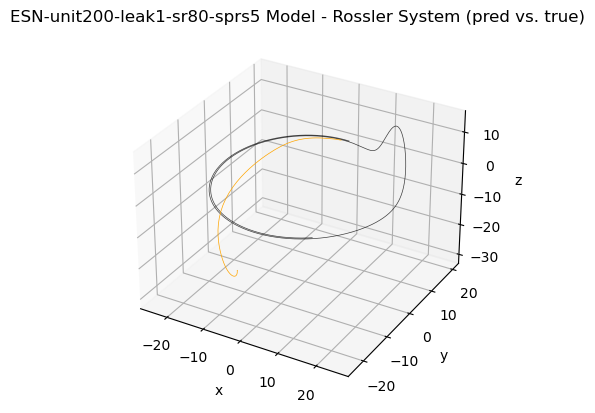

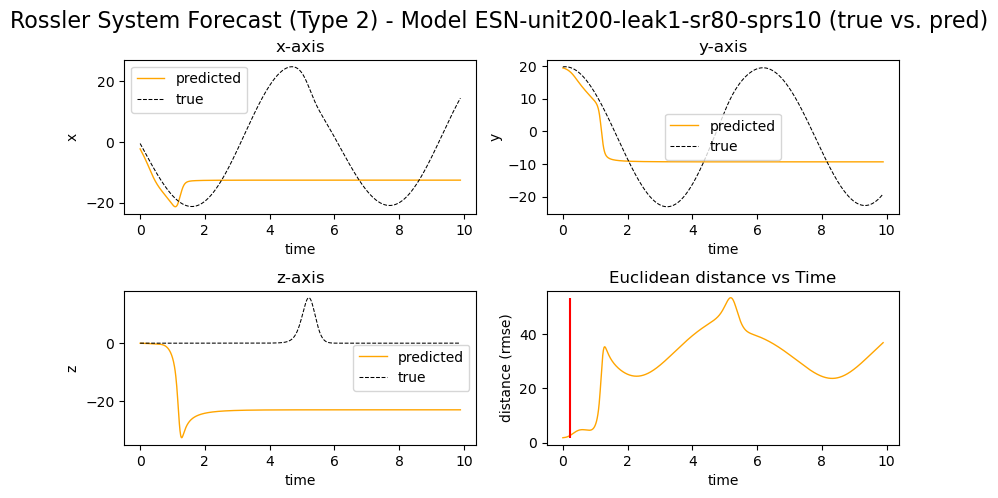

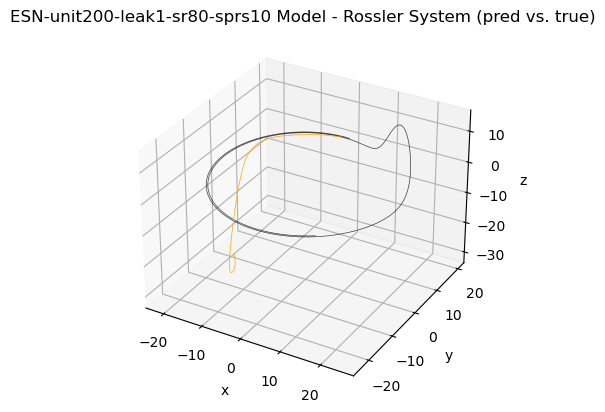

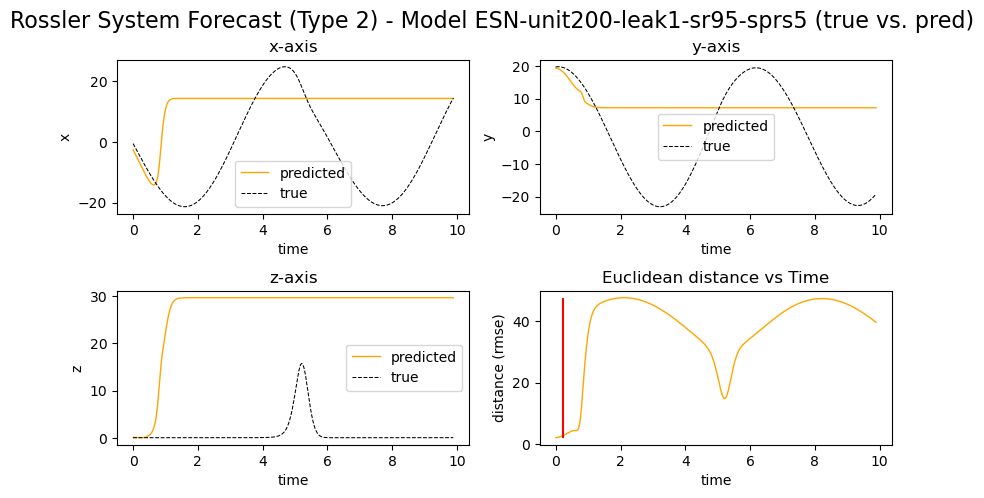

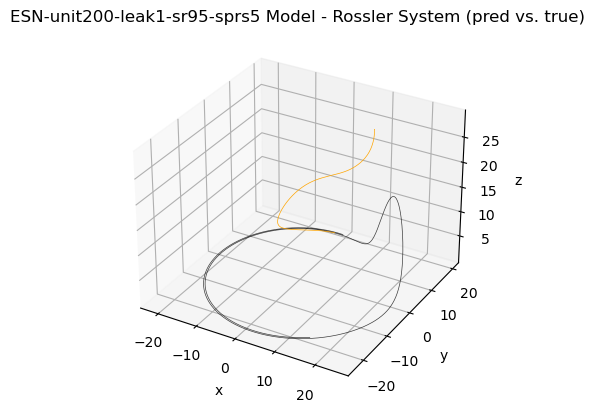

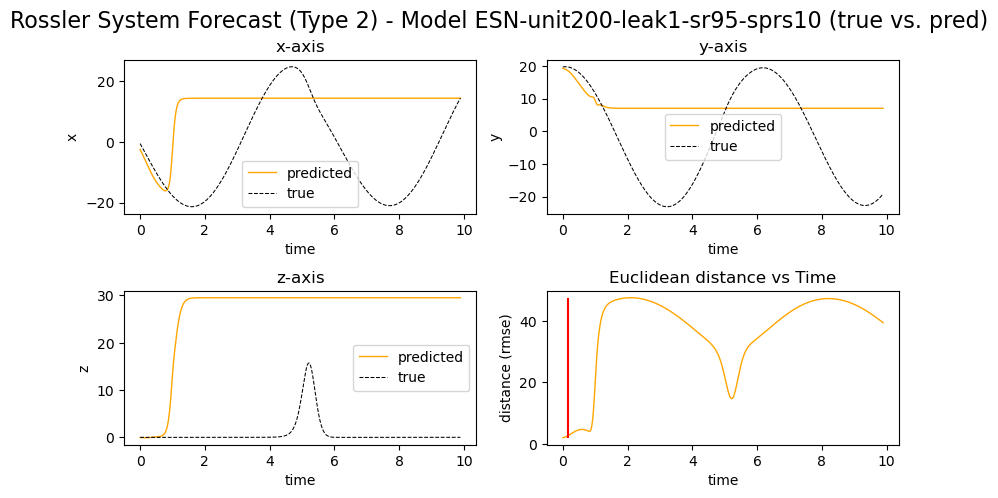

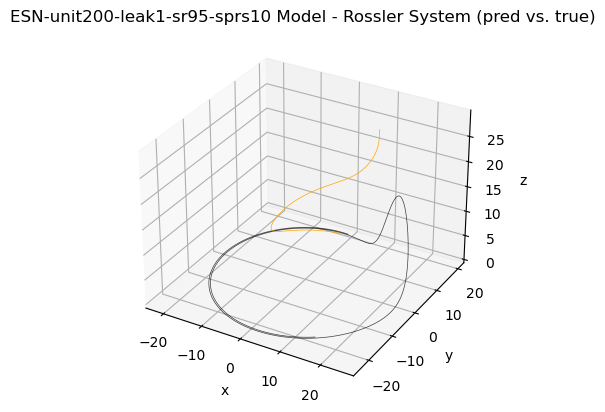

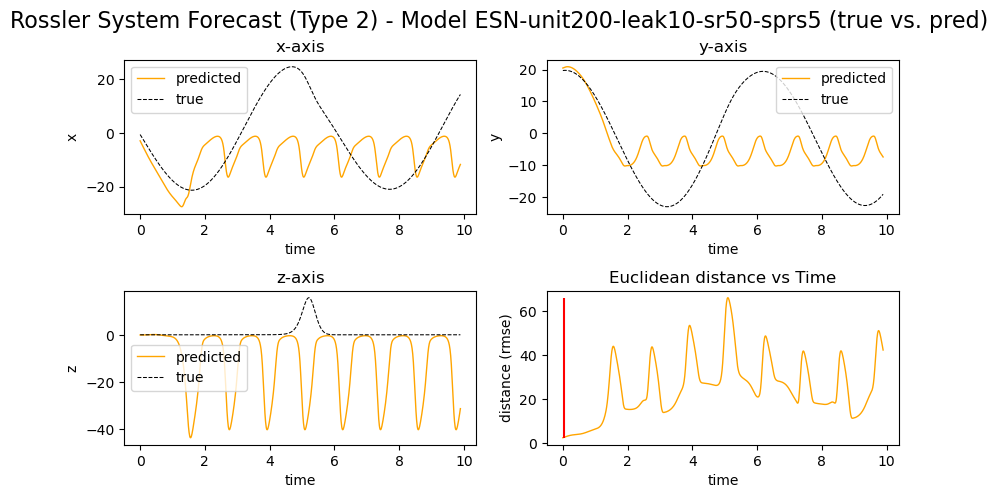

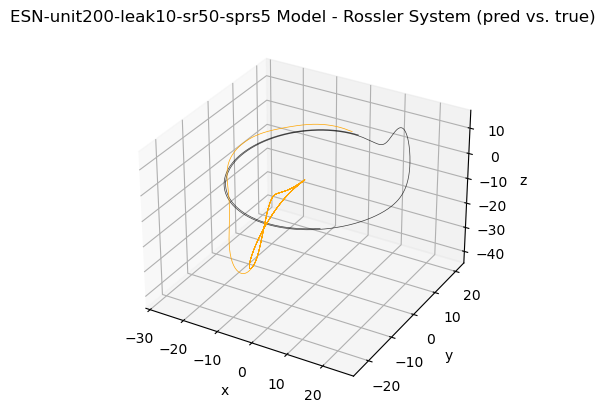

In [39]:
leaky_list = [0.01,0.1,0.5]
spectral_radius_list = [0.5,0.8,0.95]
sparsity_list = [0.05, 0.1]
neurons = 200
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50,100],[1e-2,1e-3,1e-4])

ESNmodel_list = []; ESNmodel_history = []; ESNmodel_pred = []
for leak in leaky_list:
    for spec_rad in spectral_radius_list:
        for sparse in sparsity_list:
            print('Model unit{} leaky {} spec rad {} saprsity {}'.format(neurons,int(100*leak),int(100*spec_rad), int(100*sparse)))
            
            model = tf.keras.Sequential([tfa.layers.ESN(neurons, connectivity = sparse, leaky = leak, spectral_radius = spec_rad),
                                         layers.Dense(3)])
            
            model.compile(loss=tf.keras.losses.Huber(),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                             metrics=['mse'])
            
            ESNmodel_list.append(model)
            
            historyESN = model.fit(train_input, train_output, verbose=1, epochs=150)
            ESNmodel_history.append(historyESN)
            
            esn_pred=forcast_t2(model=model,test_input=test_input,in_steps=10,samples=1000)
            ESNmodel_pred.append(esn_pred)
            plot(pred_data=esn_pred[:-1], true_data=test_data[:-1], 
                 model_name='ESN-unit{}-leak{}-sr{}-sprs{}'.format(neurons,int(100*leak),int(100*spec_rad), int(100*sparse)))
